In [1]:
%matplotlib inline
import plotting_Boyle as plt_B
reload(plt_B)
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');
import sys 
sys.path.append('../code_general/')
from read_model_ID import unpack_parameters
import CRISPR_free_energy_landscape as FreeEnergy
reload(FreeEnergy);
import plotting_Boyle as plt_B
reload(plt_B)
import CRISPR_dCas9_binding_curve_Boyle as dCas9
reload(dCas9);

import analysis_SA_fits as SAfits
reload(SAfits);



import Boyle_data_processing as Bdata
reload(Bdata);

import read_model_ID;
reload(read_model_ID);

# step 1: Use SA fit to association data from Boyle et al. 

Using simmulated annealing we minimise the $\chi^2$ based on the data with singly and doubly mismatched sequences.
Here we show our best fit.

In [5]:
simset = []
no_good = []

chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,51):
    sa = pd.read_csv('../data/15_1_2019/fit_15_1_2019_sim_' +str(sim)+'.txt', delimiter='\t', index_col=45)
    filename = '../data/15_1_2019/fit_15_1_2019_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
    

    
    
best_fit = simset[np.argmin(chi_squared)]

In [12]:
np.argsort(chi_squared)

array([23, 14, 29, 28, 10, 20, 43,  4, 16, 49,  0, 46, 33, 48, 38, 35, 31,
       24, 17, 26, 39, 21, 22, 36, 15, 30, 47, 18, 45,  8,  1, 37, 27, 34,
       41,  9, 13, 40,  7, 44,  2, 42,  5, 11, 32, 12, 25, 19,  6,  3])

In [6]:
best_fit 

'../data/15_1_2019/fit_15_1_2019_sim_24.txt'

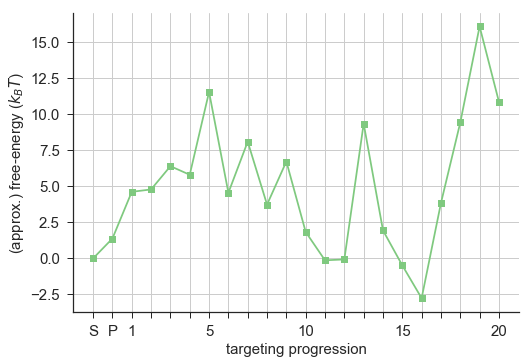

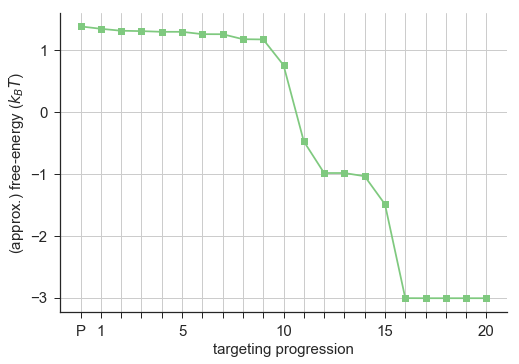

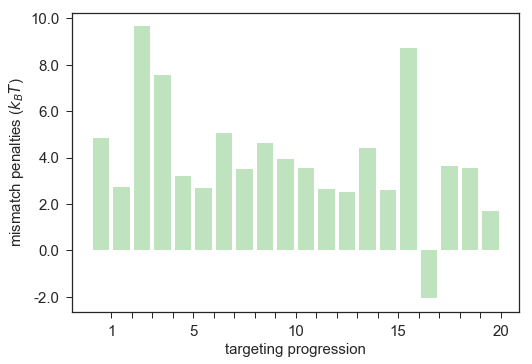

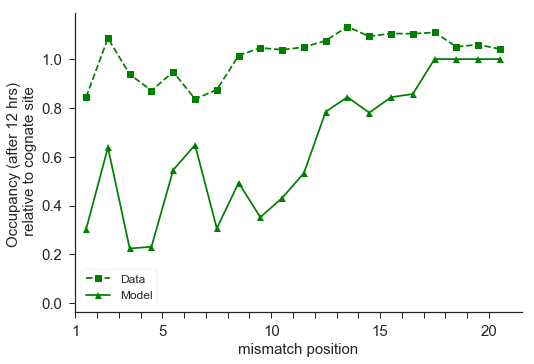

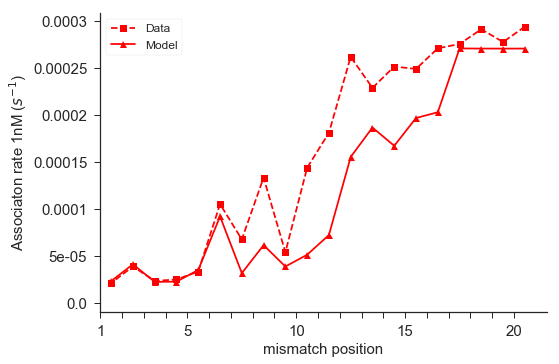

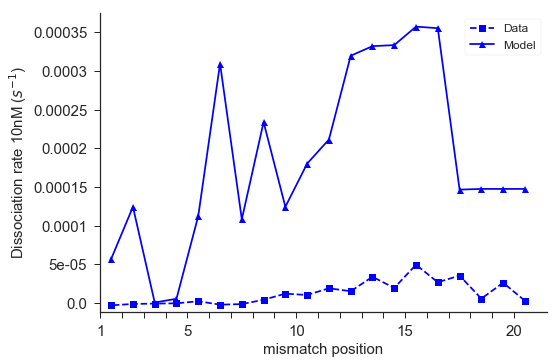

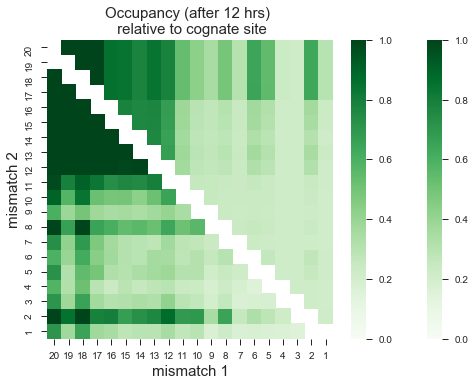

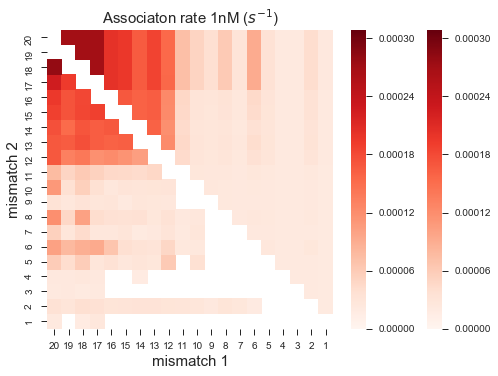

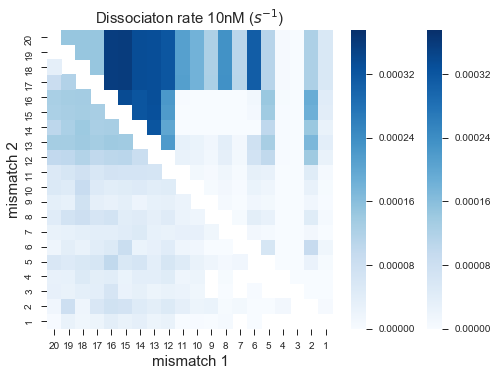

In [17]:
model_id = 'general_energies_no_kPR'
filename = simset[np.argsort(chi_squared)[3]]
Nparams = 43
parameters = plt_B.load_simm_anneal(filename, Nparams)




Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters,model_id)


Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id);

plt.figure()
FreeEnergy.plot_mismatch_penalties(parameters, model_id)


plt.figure()
_,_ = plt_B.plot_single_mismatches(Model_pbound ,kind='Occupancy')

plt.figure()
_,_ = plt_B.plot_single_mismatches(Model_on ,kind='OnRate')

plt.figure()
_,_ = plt_B.plot_single_mismatches(Model_off ,kind='OffRate')

plt.figure()
_,_ = plt_B.plot_heatmap(Model_pbound ,kind='Occupancy')

plt.figure()
_,_ = plt_B.plot_heatmap(Model_on ,kind='OnRate')

plt.figure()
_,_ = plt_B.plot_heatmap(Model_off ,kind='OffRate')


# step 2: How certain are we about each fitted parameter value? 

As we suspect we used more parameters than the number of degrees of freedom the data is able to pinpoint, we attempt to determine the robustness with which we can determine each fit parameter. 
To do such, we repeated our fits multiple times and kept those that predict association rates similar to the best fit. We say that if the 'Relative Difference in Predicted Values' (RDPV) is less than 5% (RDPV<0.05), the two fit results are equally good predictors of the data and are therefore equally vallid.

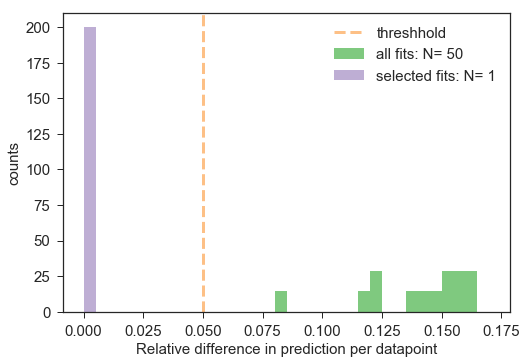

In [16]:
# scores = np.loadtxt('../data/25_10_2018/select_with_predcitions.txt')
selected_sims, selected_scores, scores = SAfits.select_on_prediction(simset, 
                                                         chi_squared, 
                                                         percentage=0.05,
                                                         Nparams=43,
                                                         model_id='general_energies_no_kPR',
                                                         precalculated=False, 
#                                                          score=scores,
                                                         save_scores=True, 
                                                         filename='../data/15_1_2019/select_with_predcitions.txt'
                                                         )
plt.hist(scores, normed=True, bins=np.arange(0,0.175,0.005), label='all fits: N= ' +str(len(scores)))
plt.hist(selected_scores,normed=True, bins=np.arange(0,0.175,0.005), label='selected fits: N= ' +str(len(selected_scores)));

plt.axvline(0.05, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);

plt.yticks(fontsize=15);